# Import Libraries

In [15]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from wordcloud import WordCloud
from collections import Counter

# Load Serialised Data

In [6]:
# Load the processed DataFrame
df = pd.read_hdf('../data/processed/processed_data.h5', key='df')

# Load the padded sequences
with h5py.File('../data/processed/padded_sequences.h5', 'r') as f:
    padded_sequences = f['padded_sequences'][:]

# Load the tokeniser
with open('../data/processed/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Display basic information about the DataFrame
print(df.info())



<class 'pandas.core.frame.DataFrame'>
Index: 72095 entries, 0 to 72133
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          72095 non-null  object
 1   text           72095 non-null  object
 2   label          72095 non-null  int64 
 3   combined_text  72095 non-null  object
 4   cleaned_text   72095 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.3+ MB
None


In [7]:
df.head()

,title,text,label,combined_text,cleaned_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,law enforcement high alert following threats c...
1,No Title,Did they post their votes for Hillary already?,1,No Title Did they post their votes for Hillary...,title post vote hillary already
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,unbelievable obamas attorney general says char...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",bobby jindal raised hindu us story christian c...
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,satan russia unvelis image terrifying new supe...


## 1. Class Distribution Analysis

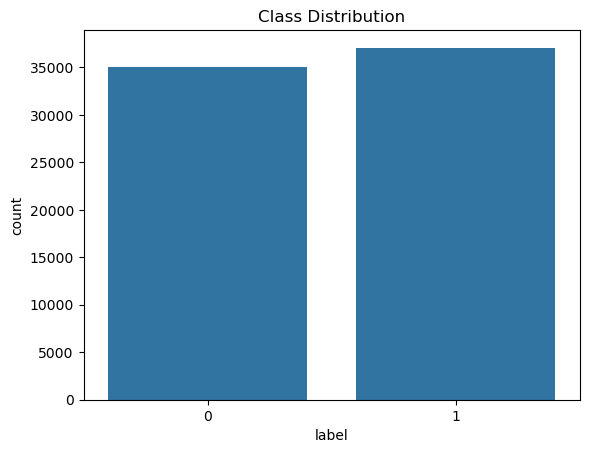

label
1    37067
0    35028
Name: count, dtype: int64


In [8]:
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()

# Display the actual counts
print(df['label'].value_counts())

## 2. Text Length Distribution

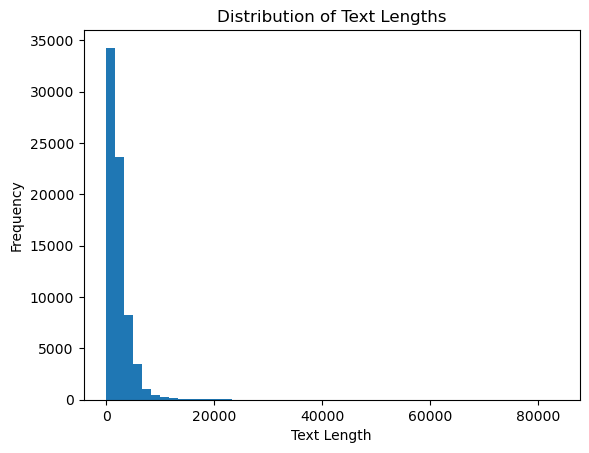

count    72095.000000
mean      2314.284749
std       2505.732415
min          0.000000
25%       1019.000000
50%       1741.000000
75%       2877.500000
max      83571.000000
Name: text_length, dtype: float64


In [9]:
df['text_length'] = df['cleaned_text'].apply(len)

plt.hist(df['text_length'], bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Display summary statistics for text lengths
print(df['text_length'].describe())

Given the skewness of the data, particularly in the distribution of text lengths, there are a few strategies one might consider to improve one's model outcomes. Here are some recommendations:

1. **Truncate Long Sequences**
Extremely long sequences may introduce noise or overwhelm your model, especially if they are outliers. Consider truncating sequences that are longer than a certain threshold (e.g., the 95th or 99th percentile of text length). You've already padded sequences to a maximum length, so this step might involve ensuring that your max sequence length is appropriate.
2. **Handling Short Sequences**
Very short sequences might not provide enough information for the model to make accurate predictions. You can consider filtering out sequences that are too short, or alternatively, use techniques like padding to handle them appropriately.
3. **Apply Data Augmentation**
If the skewness is related to a class imbalance (e.g., more real news than fake news), you might want to apply data augmentation techniques. This could include oversampling the minority class or using synthetic data generation techniques like SMOTE.
4. **Normalisation or Standardisation**
For numerical features (e.g., text_length), normalisation or standardisation can help mitigate the impact of skewness. However, since you are working primarily with text data, this might be more applicable to secondary features you might engineer from the text.
5. **Use Robust Models**
Some models are more robust to skewed data than others. For example, tree-based models like Random Forest or Gradient Boosting can handle skewed data better. Alternatively, you could explore models that specifically account for skewness.
6. **Balancing the Dataset**
If the skewness is related to an imbalance in the labels (e.g., more fake news than real news), you can balance the dataset by undersampling the majority class or oversampling the minority class. However, this needs to be done carefully to avoid overfitting, especially when oversampling.
7. **Use Log Transformation**
If the skewness is extreme, consider applying a log transformation to reduce the impact of outliers. However, this is generally more applicable to continuous numerical features rather than text lengths.

## 3. Word Cloud

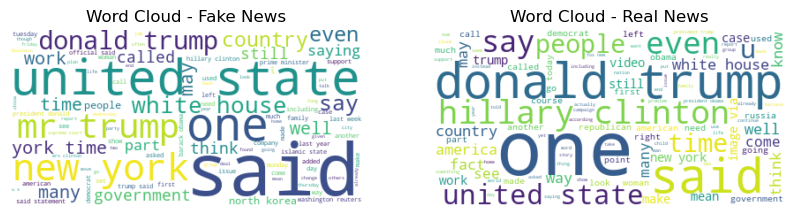

In [13]:
fake_news_text = ' '.join(df[df['label'] == 0]['cleaned_text'])
real_news_text = ' '.join(df[df['label'] == 1]['cleaned_text'])

fake_wordcloud = WordCloud(max_words=100, background_color='white').generate(fake_news_text)
real_wordcloud = WordCloud(max_words=100, background_color='white').generate(real_news_text)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Fake News')

plt.subplot(1, 2, 2)
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Real News')

plt.show()

## 4. Most Common Words

In [16]:
fake_words = ' '.join(df[df['label'] == 0]['cleaned_text']).split()
real_words = ' '.join(df[df['label'] == 1]['cleaned_text']).split()

fake_word_counts = Counter(fake_words).most_common(10)
real_word_counts = Counter(real_words).most_common(10)

print("Most common words in fake news:", fake_word_counts)
print("Most common words in real news:", real_word_counts)

Most common words in fake news: [('said', 184625), ('trump', 90859), ('mr', 66097), ('would', 62656), ('president', 51066), ('new', 50062), ('us', 48582), ('state', 47122), ('year', 46200), ('one', 43608)]
Most common words in real news: [('trump', 105582), ('people', 48821), ('said', 47143), ('one', 46036), ('would', 43146), ('clinton', 41855), ('president', 37794), ('us', 36470), ('hillary', 32281), ('like', 32276)]


## 5. Check for Duplicate Entries

In [17]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 8456


In [18]:
# Identify and review duplicates
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
print(duplicate_rows.head())

# Remove exact duplicates
df_cleaned = df.drop_duplicates()

# Confirm removal
print(f"Number of rows after removing duplicates: {df_cleaned.shape[0]}")


Number of duplicate rows: 8456
                                                  title  \
873   Just Weeks After Obama’s Executive Order on Ca...   
1192  Sports Bar Owner Bans NFL Games…Will Show Only...   
1508  HILARIOUS! LIBERALS STUNNED When Republican Gu...   
1632  Strange: Trump ‘Internet Takeover’ Fear Story ...   
1661  WOW! HILLARY Took State Department Furniture T...   

                                                   text  label  \
873   By Melissa Dykes This has already been the cra...      1   
1192  The owner of the Ringling Bar, located south o...      1   
1508  On Saturday, MSNBC s Joy Reid repeatedly attem...      1   
1632  21st Century Wire says A red flag went up when...      1   
1661  Most of the documents are testimonies provided...      1   

                                          combined_text  \
873   Just Weeks After Obama’s Executive Order on Ca...   
1192  Sports Bar Owner Bans NFL Games…Will Show Only...   
1508  HILARIOUS! LIBERALS STUNNED When R

## 6. Correlation Analysis

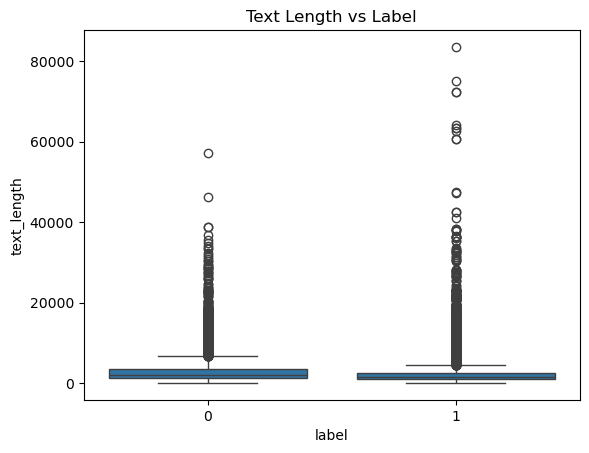

In [19]:
sns.boxplot(x='label', y='text_length', data=df)
plt.title('Text Length vs Label')
plt.show()

## 7. Visualising Data Distribution

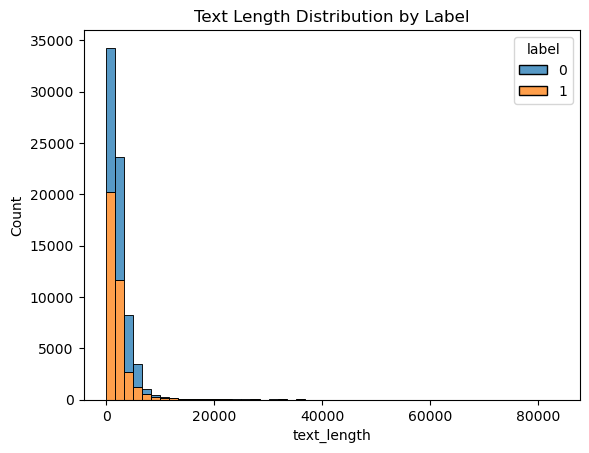

In [20]:
sns.histplot(data=df, x='text_length', hue='label', multiple='stack', bins=50)
plt.title('Text Length Distribution by Label')
plt.show()